# Data Exploration

This notebook explores the Reddit data collected for our cross-lingual stance detection project on climate change discussions, including preliminary stance analysis.

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob

In [23]:
# Load the data
latest_file = max(glob.glob('../data/raw/*.csv'), key=os.path.getctime)
data = pd.read_csv(latest_file)
print(f"Loaded {len(data)} posts")
data.head()

Loaded 8056 posts


,id,title,body,score,num_comments,created_utc,language,subreddit
0,wu9zny,The r/climatechange Verified User Flair Program,r/climatechange is a community centered around...,42,20,2022-08-21 16:53:23,en,climatechange
1,1fs8r56,World’s quandary on climate change: ‘Who the h...,NaN,119,54,2024-09-29 12:46:03,en,climatechange
2,1fsatf6,‘Like an apocalypse’: ETSU witnesses Helene’s ...,East Tennessee State Coach Tre Lamb couldn’t h...,55,28,2024-09-29 14:14:43,en,climatechange
3,1fsetc2,Can things like batteries be manufactured with...,So often I hear that the main problem with cle...,10,32,2024-09-29 17:07:51,en,climatechange
4,1fshk5r,Are there any good news about how humans have ...,"Hello, I'm seeing news about how humans have c...",6,22,2024-09-29 19:16:33,en,climatechange


## 1. Basic Statistics

In [24]:
print(data.describe())
print("\nData distribution by language:")
print(data['language'].value_counts())

             score  num_comments
count  8056.000000   8056.000000
mean     38.278923     14.483987
std     109.421838     42.672308
min       0.000000      0.000000
25%       2.000000      0.000000
50%      10.000000      2.000000
75%      35.000000     12.000000
max    3983.000000   1213.000000

Data distribution by language:
language
en    3953
de    1993
it     996
fr     984
es     130
Name: count, dtype: int64


## 2. Time Series Analysis

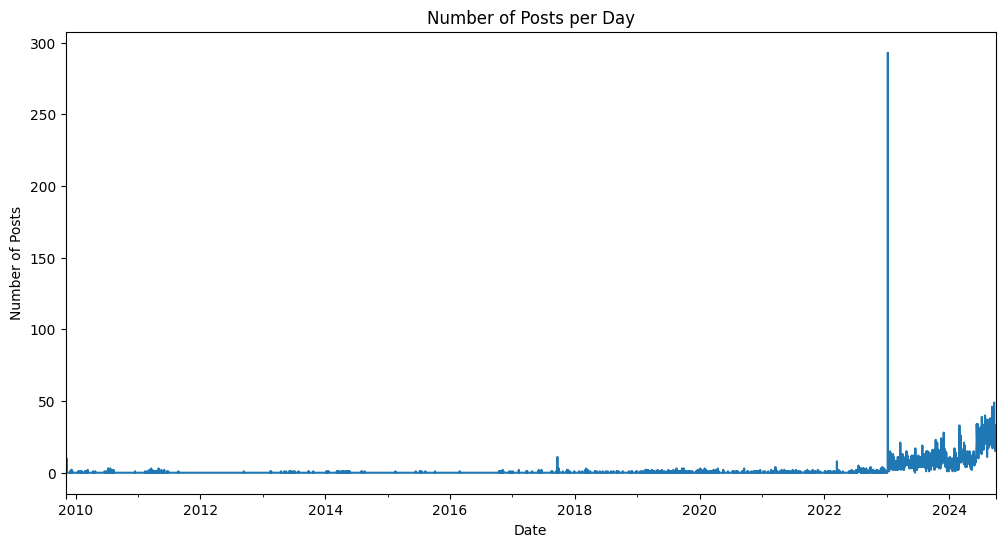

In [25]:
data['created_utc'] = pd.to_datetime(data['created_utc'])
data.set_index('created_utc', inplace=True)
daily_posts = data.resample('D').size()

plt.figure(figsize=(12, 6))
daily_posts.plot()
plt.title('Number of Posts per Day')
plt.xlabel('Date')
plt.ylabel('Number of Posts')
plt.show()

## 3. Language-specific Analysis

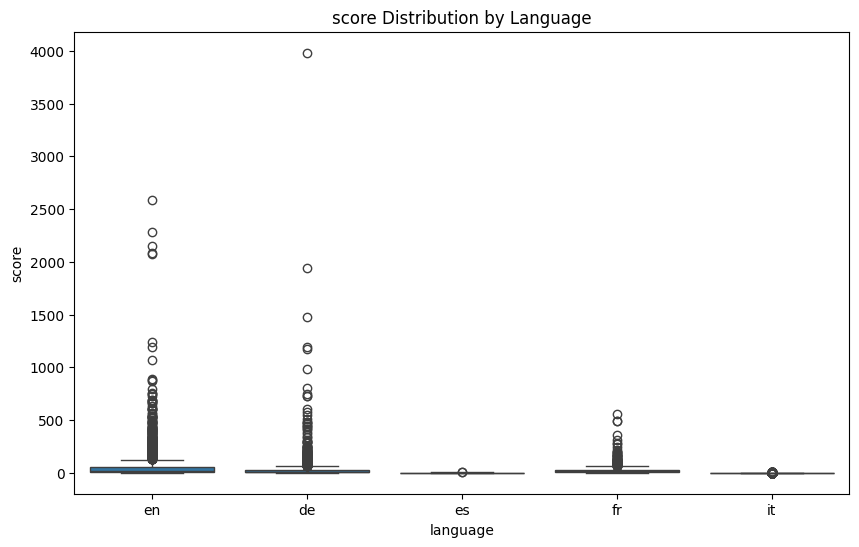

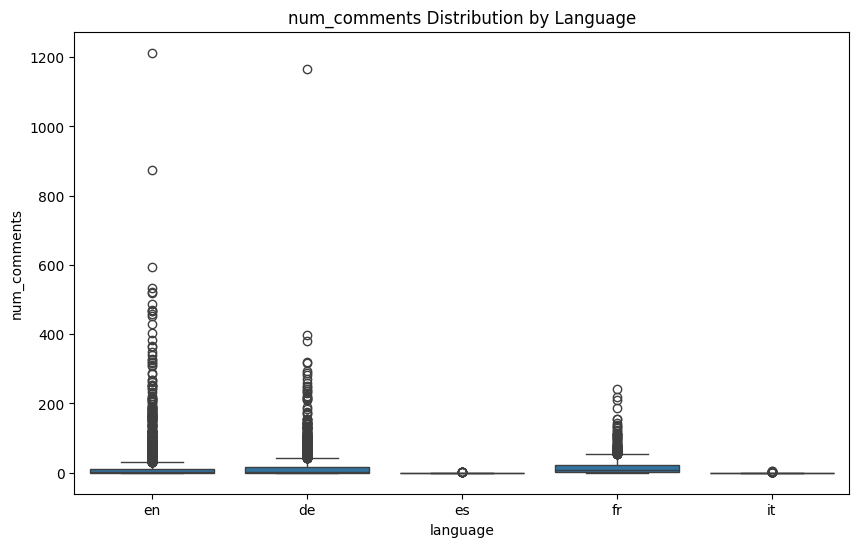

In [26]:
def plot_language_stats(data, column):
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='language', y=column, data=data)
    plt.title(f'{column} Distribution by Language')
    plt.show()

plot_language_stats(data, 'score')
plot_language_stats(data, 'num_comments')

## 4. Content Analysis

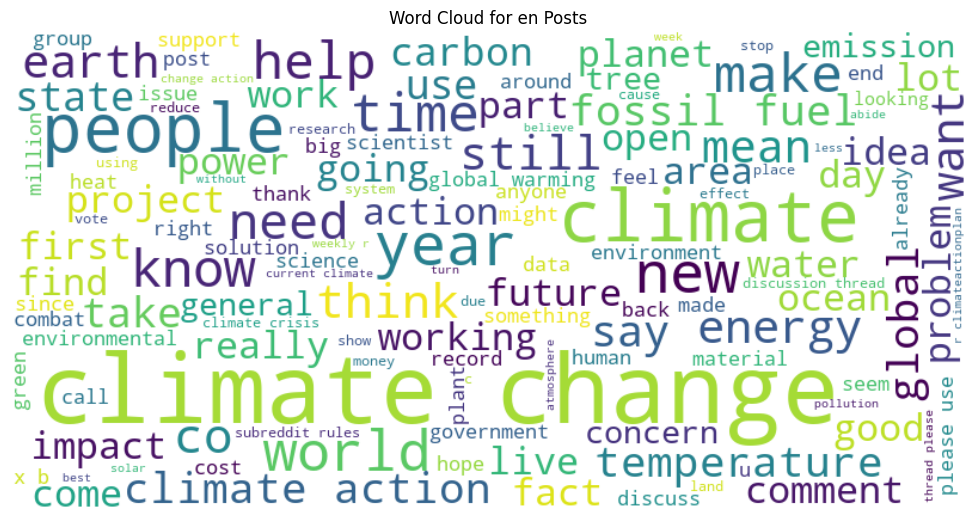

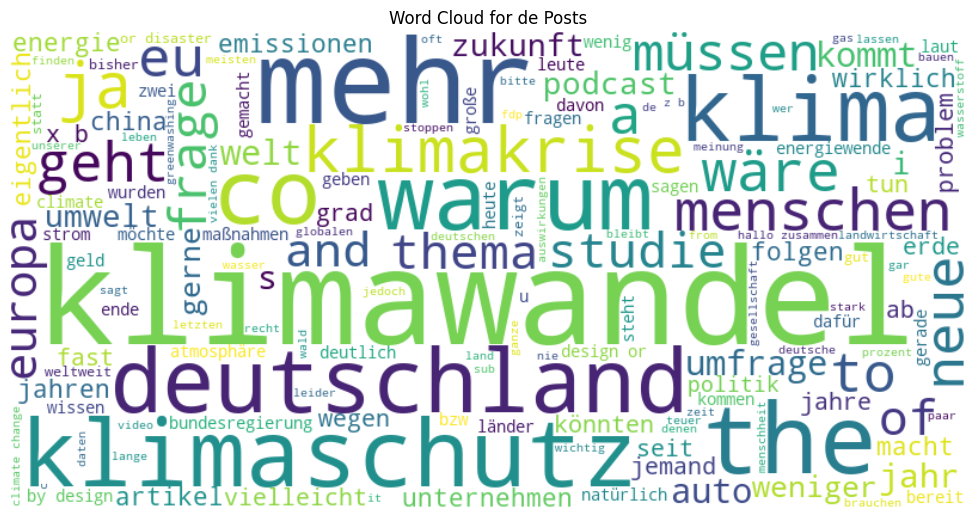

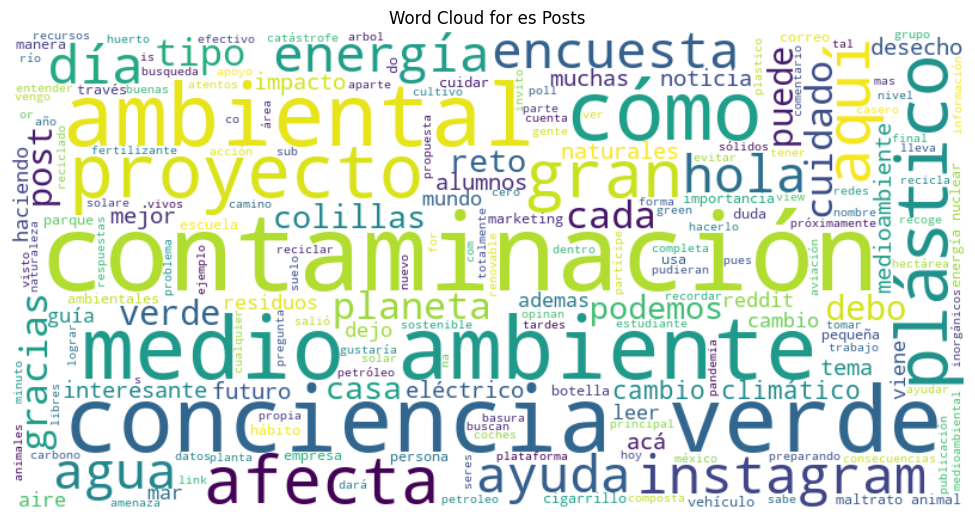

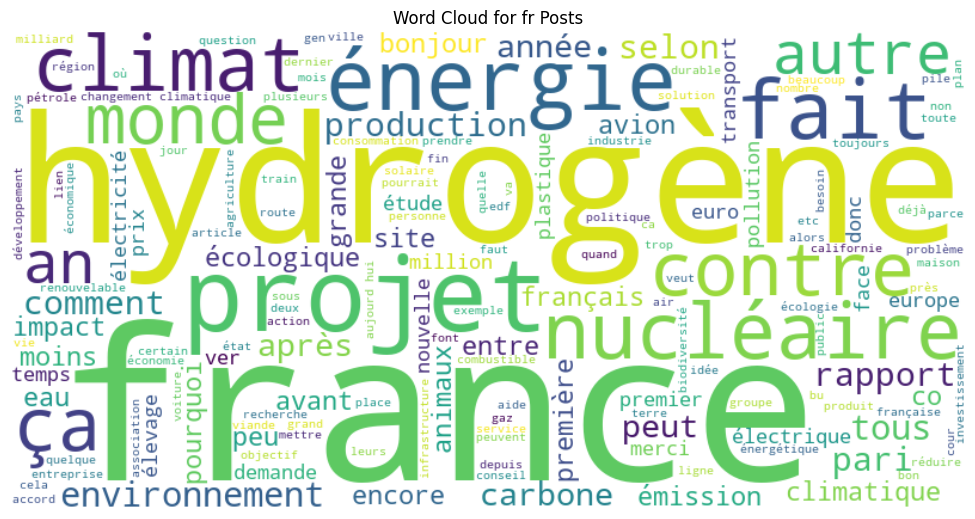

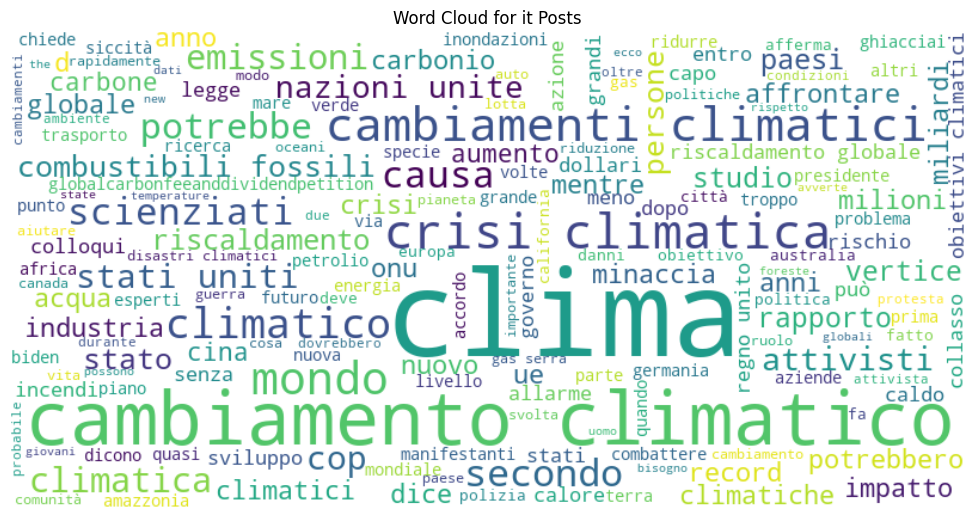

In [37]:
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
import re

# Download NLTK stop words data
nltk.download('stopwords', quiet=True)

def clean_text_func(text, language):
    # Convert to lowercase
    text = text.lower()
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # Remove special characters and digits
    text = re.sub(r'\W|\d', ' ', text)
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def get_custom_stop_words(lang):
    custom_stop_words = {
        'english': {'like', 'just', 'get', 'go', 'would', 'could', 'should', 'us', 'one', 'also', 'may', 'well', 'even', 'much', 'many', 'see', 'way'},
        'german': {'mal', 'schon', 'einfach', 'ganz', 'viele', 'viel', 'immer', 'beim', 'gibt', 'sehr', 'kann', 'werden', 'wurde', 'dabei'},
        'spanish': {'si', 'como', 'que', 'esto', 'esta', 'hay', 'ser', 'estar', 'hacer', 'poder', 'más', 'muy', 'todo', 'también'},
        'french': {'cette', 'tout', 'comme', 'plus', 'être', 'faire', 'avoir', 'pouvoir', 'leur', 'même', 'aussi', 'bien', 'très', 'sans', 'a', 'ici', 'si'},
        'italian': {'che', 'come', 'anche', 'più', 'essere', 'fare', 'potere', 'dovere', 'molto', 'tutto', 'ancora', 'bene', 'proprio', 'solo'}
    }
    return custom_stop_words.get(lang, set())

def generate_wordcloud(text, title, language):
    # Get stop words for the specified language
    stop_words = set(stopwords.words(language))
    
    # Add custom stop words
    custom_stop_words = get_custom_stop_words(language)
    stop_words.update(custom_stop_words)
    
    # Create and generate a word cloud image
    wordcloud = WordCloud(width=800, height=400, background_color='white', 
                          stopwords=stop_words, min_font_size=10).generate(text)
    
    # Display the generated image
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.tight_layout(pad=0)
    plt.show()

# Map language codes to NLTK language names
language_map = {
    'en': 'english',
    'de': 'german',
    'es': 'spanish',
    'fr': 'french',
    'it': 'italian'
}

for lang in data['language'].unique():
    lang_data = data[data['language'] == lang]
    
    # Combine title and body, handle NaN values
    text = lang_data['title'].fillna('') + ' ' + lang_data['body'].fillna('')
    
    # Clean the text
    cleaned_text = ' '.join([clean_text_func(t, language_map.get(lang, 'english')) for t in text])
    
    # Generate word cloud
    generate_wordcloud(cleaned_text, f'Word Cloud for {lang} Posts', language_map.get(lang, 'english'))

## 5. Preliminary Stance Analysis

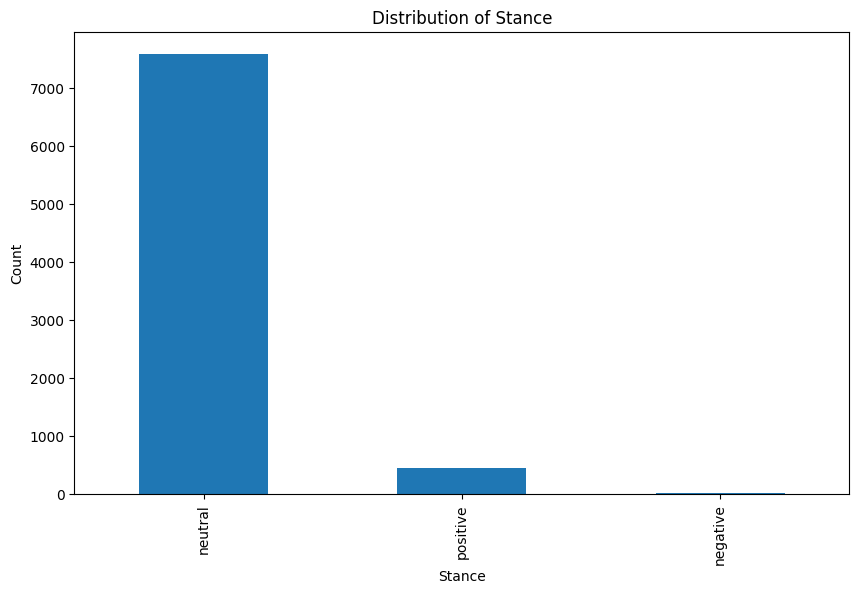

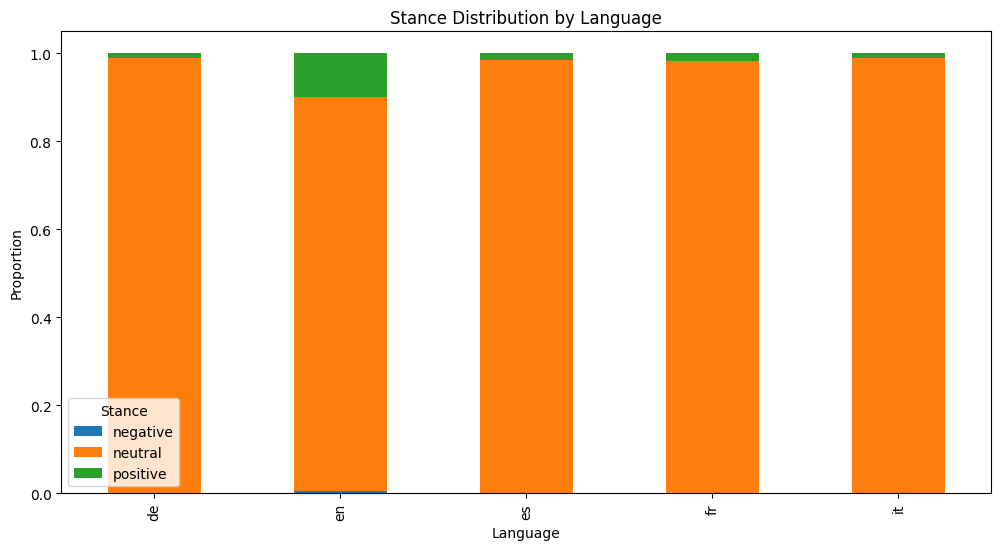

In [28]:
def assign_stance(text):
    text = text.lower()
    positive_keywords = ['support', 'agree', 'real', 'serious', 'urgent', 'action']
    negative_keywords = ['hoax', 'fake', 'exaggerated', 'myth', 'scam', 'conspiracy']
    
    positive_count = sum(1 for keyword in positive_keywords if keyword in text)
    negative_count = sum(1 for keyword in negative_keywords if keyword in text)
    
    if positive_count > negative_count:
        return 'positive'
    elif negative_count > positive_count:
        return 'negative'
    else:
        return 'neutral'

data['stance'] = data['title'].apply(assign_stance)

plt.figure(figsize=(10, 6))
data['stance'].value_counts().plot(kind='bar')
plt.title('Distribution of Stance')
plt.xlabel('Stance')
plt.ylabel('Count')
plt.show()

# Stance distribution by language
stance_by_lang = pd.crosstab(data['language'], data['stance'], normalize='index')
stance_by_lang.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.title('Stance Distribution by Language')
plt.xlabel('Language')
plt.ylabel('Proportion')
plt.legend(title='Stance')
plt.show()

## 6. Conclusions and Initial Insights

Based on this exploratory analysis, we can draw some initial conclusions and outline next steps:

1. Data Distribution and Language Representation:
   - English dominates the dataset with 3953 posts, followed by German (1993 posts).
   - Italian and French have similar representation (~990 posts each).
   - Spanish is significantly underrepresented with only 130 posts.

2. Temporal Trends:
   - A dramatic increase in posting activity is observed from late 2022 onwards.
   - The period 2023-2024 shows a massive spike, with one day reaching nearly 300 posts.
   - This recent surge suggests growing public interest and concern about climate change.

3. Content Analysis by Language:
   - English: Broad global perspective, focus on "climate change", action-oriented language.
   - German: Strong national focus ("Deutschland"), emphasis on "Klimakrise" (climate crisis).
   - Spanish: Emphasis on environmental issues, pollution, and water-related concerns.
   - French: Dominated by energy discussions, particularly hydrogen and nuclear.
   - Italian: Focus on "crisi climatica" (climate crisis) and climate activism.

4. Engagement Metrics:
   - High variability in post scores (mean 38.28, median 10) indicates a few highly popular posts.
   - Comments show similar variability (mean 14.48, median 2).
   - Some posts generated extensive discussion (max 1213 comments), likely on controversial or highly engaging topics.

5. Stance Analysis:
   - Neutral stance predominates across all languages.
   - Positive stances outweigh negative ones in all languages.
   - German posts show a slightly higher proportion of positive stances.
   - Spanish posts have the highest proportion of neutral stances.

6. Cross-Language Insights:
   - While climate change is a universal theme, each language community focuses on different aspects.
   - National perspectives are strong in German and French discussions.
   - Energy solutions are prominently discussed in French and German posts.
   - Environmental pollution and water issues are uniquely emphasized in Spanish content.
   - Italian discussions highlight the crisis aspect and climate activism.

7. Emerging Trends:
   - The recent spike in posting activity coincides with more action-oriented and solution-focused discussions.
   - Energy transitions, particularly towards hydrogen and nuclear, are gaining traction, especially in French discourse.
   - There's an increasing focus on the local impacts of global climate change, as seen in the nation-specific discussions.

These findings highlight the complex and multifaceted nature of climate change discussions across different language communities. The varying focuses reflect local priorities, national policies, and cultural perspectives on this global issue. The recent surge in activity suggests that climate change is becoming an increasingly urgent topic of public discourse.